<h3>Import libraries</h3>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import gensim 
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Input, Dropout
from keras.layers import Bidirectional, LSTM, Activation
from keras.models import model_from_json

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [18]:
def save_fig(fig_id):
    print("Saving figure", fig_id)
    plt.savefig(os.getcwd()+"/"+fig_id, format="png", dpi=300)

<h3>Load data</h3>

<h3>Tokenizer</h3>

In [3]:
data = pd.read_csv("data_with_tokens.csv")
data=data.dropna()

<h3>Bag of Words Counts</h3>


In [4]:
def count_vectorize(data):
    count_vectorizer = CountVectorizer()
    
    embedding = count_vectorizer.fit_transform(data)
    
    return embedding, count_vectorizer

X = data["text"].tolist()
y = data["stars"].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_counts, count_vectorizer = count_vectorize(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [5]:
X_train_counts

<1255410x389905 sparse matrix of type '<class 'numpy.int64'>'
	with 98667654 stored elements in Compressed Sparse Row format>

<h3>Load word2vec model</h3>


In [6]:
PATH_WORD2VEC = "../../GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(PATH_WORD2VEC, binary=True,limit=500000)

<h3>Overview of the model</h3>

In [7]:
all_words = [word for tokens in data["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data["tokens"]]
vocabulary = sorted(list(set(all_words)))

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(vocabulary)
VALIDATION_SPLIT = 0.2

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(data["text"].tolist())
sequences = tokenizer.texts_to_sequences(data["text"].tolist())

word_index = tokenizer.word_index
print("Found %s unique tokens." % (len(word_index)))

train_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(data["stars"]))

indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)
train_data = train_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * train_data.shape[0])

embedding_weights = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, index in word_index.items():
    embedding_weights[index, :] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)

print("embedding_weights shape: ", embedding_weights.shape)

Found 492840 unique tokens.
embedding_weights shape:  (492841, 300)


In [8]:
def Bidir_LSTM_2layer(embeddings, max_sequence_length, num_words, \
                embedding_dim, trainable=False):
    """
    Function creating the 2-layer Bidirectional LSTM classifier's model graph
    """
    
    # Creating the embedding layer pretrained with word2vec vectors
    embedding_layer = Embedding(num_words, \
                                embedding_dim, \
                                weights=[embeddings], \
                                input_length=max_sequence_length, \
                                trainable=trainable)
    
    # define input of the graph
    sequence_input = Input(shape=(max_sequence_length, ), dtype="int32", name="Input")
    
    # Propagate sequence_input through the embedding layer, to get back the embeddings
    embedded_sequences = embedding_layer(sequence_input)    
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    X = Bidirectional(LSTM(128, return_sequences=True, name="LSTM_1"))(embedded_sequences)
    # Add dropout with probability 0.5
    X = Dropout(0.5, name="Dropout_1")(X)
    # Propagate X through another LSTM layer with 128-dimensional hidden state
    X = Bidirectional(LSTM(128, return_sequences=False, name="LSTM_2"))(X)
    # Add dropout with probability 0.5
    X = Dropout(0.5, name="Dropout_2")(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(6, name="Dense")(X)
    # Add a softmax activation
    X = Activation("softmax", name="Softmax")(X)
    
    # Create Model instance which converts sequence_input into X
    model = Model(inputs=sequence_input, outputs=X)
    
    return model

In [9]:
X_train = train_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
X_val  = train_data[-num_validation_samples:]
y_val  = labels[-num_validation_samples:]

model = Bidir_LSTM_2layer(embedding_weights, \
                          MAX_SEQUENCE_LENGTH, \
                          len(word_index)+1, \
                          EMBEDDING_DIM, \
                          trainable=False)

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 35)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 35, 300)           147852300 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 35, 256)           439296    
_________________________________________________________________
Dropout_1 (Dropout)          (None, 35, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
Dense (Dense)                (None, 6)                 1542      
__________

<h3>Training the model</h3>

As usual, after creating your model in Keras, you need to compile it and define what loss, optimizer and metrics your are want to use. Compile your model using categorical_crossentropy loss, adam optimizer and ['accuracy'] metrics:

In [11]:
model.compile(loss='categorical_crossentropy', \
              optimizer='adam', \
              metrics=['acc'])

In [12]:
from keras.callbacks import ModelCheckpoint

In [13]:
## Create checkpoint that saves the weights each time validation set at each epoch is outperformed by the last one
filepath="LSTM2layer_weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, \
                             monitor="val_acc", \
                             verbose=0, \
                             save_best_only=True, \
                             mode="max")
callbacks_list = [checkpoint]

In [14]:
history = model.fit(X_train, y_train, \
                    validation_data=(X_val, y_val), \
                    epochs=10, \
                    batch_size=512, \
                    callbacks=callbacks_list, \
                    verbose=1)

Train on 1255411 samples, validate on 313852 samples
Epoch 1/10
1255411/1255411 [==============================] - 2461s 2ms/step - loss: 1.0741 - acc: 0.5304 - val_loss: 0.9998 - val_acc: 0.5603
Epoch 2/10
1255411/1255411 [==============================] - 2464s 2ms/step - loss: 0.9798 - acc: 0.5719 - val_loss: 0.9491 - val_acc: 0.5838
Epoch 3/10
1255411/1255411 [==============================] - 2464s 2ms/step - loss: 0.9452 - acc: 0.5863 - val_loss: 0.9302 - val_acc: 0.5913
Epoch 4/10
1255411/1255411 [==============================] - 2463s 2ms/step - loss: 0.9252 - acc: 0.5945 - val_loss: 0.9172 - val_acc: 0.5983
Epoch 5/10
1255411/1255411 [==============================] - 2460s 2ms/step - loss: 0.9101 - acc: 0.6010 - val_loss: 0.9134 - val_acc: 0.5986
Epoch 6/10
1255411/1255411 [==============================] - 2455s 2ms/step - loss: 0.8972 - acc: 0.6060 - val_loss: 0.9087 - val_acc: 0.6011
Epoch 7/10
1255411/1255411 [==============================] - 2458s 2ms/step - loss: 0.88

In [15]:
# Serialize model to JSON

model_json = model.to_json()
with open("model_bidirlstm2layer.json", "w") as json_file:
    json_file.write(model_json)
    
# Serialize weights to HDF5

model.save_weights("model_bidirlstm2layer.h5")
print("Saved model to disk")

Saved model to disk


<h3>Plotting the training and validation loss</h3>

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [20]:
import os

Saving figure Bidirec_LSTM_2layer_train&valid_loss


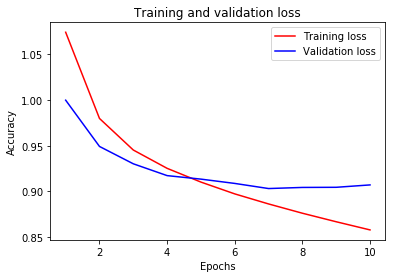

In [21]:
history_dict = history.history
train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

num_epochs = 10
epochs = range(1, num_epochs + 1)

plt.plot(epochs, train_loss_values, 'r', label="Training loss")
plt.plot(epochs, val_loss_values, 'b', label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

save_fig("Bidirec_LSTM_2layer_train&valid_loss")
plt.show()

Saving figure Bidirec_LSTM_2layer_train&valid_acc


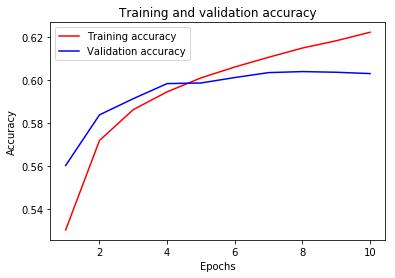

In [22]:
history_dict = history.history
train_acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

num_epochs = 10
epochs = range(1, num_epochs + 1)

plt.plot(epochs, train_acc_values, 'r', label="Training accuracy")
plt.plot(epochs, val_acc_values, 'b', label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

save_fig("Bidirec_LSTM_2layer_train&valid_acc")
plt.show()

<h3>Evaluate model</h3>

In [23]:

sequences = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index

test_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels_test = to_categorical(y_test)

indices = np.arange(test_data.shape[0])
np.random.shuffle(indices)
test_data = test_data[indices]
labels_test = labels_test[indices]



In [24]:
X_test=test_data
y_test=labels_test

In [25]:
## Evaluate model directly without loading json and hdf5 files
scores = model.evaluate(X_test, y_test)
print("%s on test data: %.2f%%" % (model.metrics_names[1], scores[1]*100))

313853/313853 [==============================] - 328s 1ms/step
acc on test data: 62.49%


In [ ]:
y_pred=model.predict(X_test, verbose=1)  

293152/313853 [===========================>..] - ETA: 21s

In [ ]:
dist=0
for i in range(len(y_pred)):
    dist+=np.abs(np.argmax(y_test[i])-np.argmax(y_pred[i]))
    
dist=dist/len(y_pred)


In [ ]:
print("In average, we are at a distance "+str(dist)+" of the groud truth, in stars")